In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import csv
import nltk
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator, Vocab
import re
import pickle
from typing import List, Tuple, Optional
from torch import swapaxes
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(13)

/home2/sanika/miniconda3/envs/smai/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def load_data(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row[1])
            labels.append(row[0])
    # delete the first element of the list (header)
    del data[0]
    del labels[0]
    return data, labels

In [4]:
# load data (the csv)
train_data, train_labels = load_data('./ANLP-2/train.csv')
test_data, test_labels = load_data('./ANLP-2/test.csv')

In [5]:
def tokenize_data(data):
    tokenized_data = []
    for text in data:
        text = re.sub(r'\\', ' ', text)
        text = re.sub(r'\"', ' ', text)
        text = re.sub(r'\d+', '<NUMBER>', text)
        text = text.lower()
        text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]', ' ', text)
        tokenized_data.append(word_tokenize(text))
    return tokenized_data

In [6]:
train_data = tokenize_data(train_data)
test_data = tokenize_data(test_data)

In [7]:
# load vocabulary
# load from pt file
vocab = torch.load('skip-gram-vocab.pt')

word_vectors = torch.load('skip-gram-word-vectors.pt')

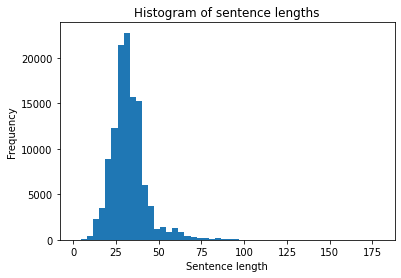

In [8]:
# print a histogram of the lengths of the sentences
import matplotlib.pyplot as plt
import numpy as np
sentence_lengths = [len(sentence) for sentence in train_data]
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.title('Histogram of sentence lengths')
plt.show()

In [9]:
OUT_OF_VOCAB = '<OOV>'
PAD_TAG = '<PAD>'
START_TAG = '<BOS>'
END_TAG = '<EOS>'

class POSDataset(Dataset):
    def __init__(self, sentences, labels, vocabulary: Optional[Vocab] = None):
        self.sentences = sentences
        self.labels = labels
        if vocabulary is None:
            self.vocab = build_vocab_from_iterator(self.sentences, specials=[OUT_OF_VOCAB, PAD_TAG])
            self.vocab.set_default_index(self.vocab[OUT_OF_VOCAB])
        else:
            self.vocab = vocabulary

        # set default index
        self.vocab.set_default_index(self.vocab[OUT_OF_VOCAB])

        # Extract unique labels
        self.labels_vocab = list(set(self.labels))
        # sort
        self.labels_vocab.sort()

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.vocab.lookup_indices(self.sentences[idx])), torch.tensor(self.labels_vocab.index(self.labels[idx]))

    def format(self, batch, encodings) -> Tuple[torch.Tensor, torch.Tensor]:
        # add <BOS> and <EOS> to the sentences
        sentences, labels = zip(*batch)
        sentences = list(sentences)
        # add <BOS> and <EOS> to the sentences
        sentences = [torch.tensor([self.vocab[START_TAG]] + list(s) + [self.vocab[END_TAG]]) for s in sentences]

        sentences = pad_sequence(sentences, padding_value=self.vocab[PAD_TAG])
        sentences = swapaxes(sentences, 0, 1)

        # cut sentences off at length 50
        sentences = sentences[:, :40]

        # one hot encode the labels
        labels = [torch.nn.functional.one_hot(torch.tensor(l), num_classes=len(self.labels_vocab)) for l in labels]

        # encodings is a dictionary with each index corresponding to a word encoding. Map those to the sentences
        # convert sentences to a list of list of tensors
        sentences = [[encodings[int(i)] for i in s] for s in sentences]

        # zip and return
        return list(zip(sentences, labels))

        


In [10]:
train_dataset = POSDataset(train_data, train_labels, vocab)
test_dataset = POSDataset(test_data, test_labels, vocab)

In [11]:
train = train_dataset.format(train_dataset, word_vectors)
test = test_dataset.format(test_dataset, word_vectors)

/home2/sanika/miniconda3/envs/smai/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
# split train into train and validation
train_size = int(0.8 * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size, val_size])

In [13]:
loaders = {
    'train': DataLoader(train, batch_size=128, shuffle=True),
    'test': DataLoader(test, batch_size=128, shuffle=False),
    'val': DataLoader(val, batch_size=128, shuffle=False)
}

In [23]:
class RNN_News_Classification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text):
        output, (hidden, cell) = self.rnn(text)
        final_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(final_output)
        return output

    def fit(self, loaders, optimizer, criterion, n_epochs, device):
        self.to(device)
        self.train()
        for epoch in range(n_epochs):
            self.train()
            total_loss = 0  
            for i, (sentences, labels) in enumerate(loaders['train']):
                # convert sentences to tensors
                # sentences = sentences.to(device)
                sentences = torch.stack(sentences).to(device)
                sentences = sentences.permute(1, 0, 2)
                labels = labels.to(device)
                optimizer.zero_grad()
                output = self(sentences)
                labels = labels.float()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}') 
            print(f'Loss: {total_loss/len(loaders["train"])}')
            
            # evaluate
            self.eval()
            correct = 0
            total = 0
            total_loss = 0
            with torch.no_grad():
                for i, (sentences, labels) in enumerate(loaders['val']):
                    # convert to tensors
                    # sentences = sentences.to(device)
                    sentences = torch.stack(sentences).to(device)
                    sentences = sentences.permute(1, 0, 2)
                    labels = labels.to(device)
                    output = self(sentences)
                    predicted = torch.argmax(output, dim=1)
                    total += labels.size(0)
                    original = torch.argmax(labels, dim=1)
                    correct += (predicted == original).sum().item()
                    labels = labels.float()
                    loss = criterion(output, labels)
                    total_loss += loss.item()
            print(f'Validation Loss: {total_loss/len(loaders["val"])}')
            print(f'Validation Accuracy: {correct/total}')

            
    def evaluate(self, loaders, device):
        self.to(device)
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (sentences, labels) in enumerate(loaders['test']):
                # convert to tensors
                sentences = torch.stack(sentences).to(device)
                sentences = sentences.permute(1, 0, 2)
                labels = labels.to(device)
                output = self(sentences)
                predicted = torch.argmax(output, dim=1)
                labels = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Test Accuracy: {correct/total}')

In [25]:
model = RNN_News_Classification(len(vocab), 300, 128, len(train_dataset.labels_vocab), 2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

model.fit(loaders, optimizer, criterion, 10, device)

Epoch 1
Loss: 0.5329164936542511
Validation Loss: 0.3455353028913762
Validation Accuracy: 0.8785833333333334
Epoch 2
Loss: 0.2902852557897568
Validation Loss: 0.30731491950598167
Validation Accuracy: 0.8917083333333333
Epoch 3
Loss: 0.2283319307466348
Validation Loss: 0.31260934654385486
Validation Accuracy: 0.8920416666666666
Epoch 4
Loss: 0.18545235445102057
Validation Loss: 0.3097534636233715
Validation Accuracy: 0.895375
Epoch 5
Loss: 0.15315355384349824
Validation Loss: 0.3212684965989691
Validation Accuracy: 0.8969166666666667
Epoch 6
Loss: 0.1210163178667426
Validation Loss: 0.3560660979215135
Validation Accuracy: 0.8942083333333334
Epoch 7
Loss: 0.09911053586006165
Validation Loss: 0.3729638399437387
Validation Accuracy: 0.895375
Epoch 8
Loss: 0.08080336098869642
Validation Loss: 0.4146778533591869
Validation Accuracy: 0.891125
Epoch 9
Loss: 0.06580434441069762
Validation Loss: 0.44249027206542646
Validation Accuracy: 0.8879166666666667
Epoch 10
Loss: 0.05802420016067723
Valida

In [1]:
model.evaluate(loaders, device)

NameError: name 'model' is not defined